# 시계열 데이터의 Anomaly Detection 방법 비교

- RNN을 이용한 지도학습 방법 - 이진 분류
- Autoencoder 사용 방법 - 재구성 오류 측정
- Variational Autoencoder 사용 방법 - 재구성 오류 측정

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

- 이 연습문제에서는 RNN, 자동 인코더 및 변형 자동 인코더를 사용하여 [ECG5000 데이터 세트](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000)에서 이상을 감지합니다.  이 데이터 세트에는 각각 140개의 데이터 포인트가 있는 5,000개의 심전도가 포함되어 있습니다. 각 예제에 0(비정상 리듬에 해당) 또는 1(정상 리듬에 해당)로 레이블이 지정된 데이터 세트의 단순화된 버전을 사용할 것입니다. 우리는 비정상적인 리듬을 식별하는 데 관심이 있습니다.   

- "ECG5000"의 원본 데이터세트는 Physionet에서 다운로드한 20시간 길이의 ECG입니다. 이름은 BIDMC 울혈성 심부전 데이터베이스(chfdb)이고 레코드 "chf07"입니다.

## Load and prepare ECG data

In [2]:
# Dataset Download
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.608558,-0.335651,-0.990948,-1.784153,-2.626145,-2.957065,-2.931897,-2.664816,-2.090137,-1.461841,...,1.757705,2.291923,2.704595,2.451519,2.017396,1.704358,1.688542,1.629593,1.342651,0.0
4994,-2.060402,-2.860116,-3.405074,-3.748719,-3.513561,-3.006545,-2.234850,-1.593270,-1.075279,-0.976047,...,1.388947,2.079675,2.433375,2.159484,1.819747,1.534767,1.696818,1.483832,1.047612,0.0
4995,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,0.0
4996,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,0.0


In [3]:
df.iloc[:, -1].value_counts()

1.0    2919
0.0    2079
Name: 140, dtype: int64

In [4]:
# 데이터프레임의 마지막 열에 해당하는 레이블(정답)을 가져옵니다.
labels = df.iloc[:, -1]

# 심전도 데이터의 특성(feature) 값들을 가져옵니다.
data = df.iloc[:, 0:-1]

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3998, 140), (1000, 140), (3998,), (1000,))

In [5]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [6]:
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

normal, abnormal data 분리

In [7]:
normal_X_train = X_train[y_train]
normal_X_test = X_test[y_test]
normal_y_train = y_train[y_train]
normal_y_test = y_test[y_test]

abnormal_X_train = X_train[~y_train]
abnormal_X_test = X_test[~y_test]
abnormal_y_train = y_train[~y_train]
abnormal_y_test = y_test[~y_test]

print("정상 데이터", normal_X_train.shape, normal_X_test.shape,
       normal_y_train.shape, normal_y_test.shape)
print("비정상 데이터", abnormal_X_train.shape, abnormal_X_test.shape,
       abnormal_y_train.shape, abnormal_y_test.shape)

정상 데이터 (2328, 140) (591, 140) (2328,) (591,)
비정상 데이터 (1670, 140) (409, 140) (1670,) (409,)


In [8]:
train_ds = tf.data.Dataset.from_tensor_slices(normal_X_train).shuffle(10000).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices(normal_X_test).batch(128)

정상 ECG 시각화

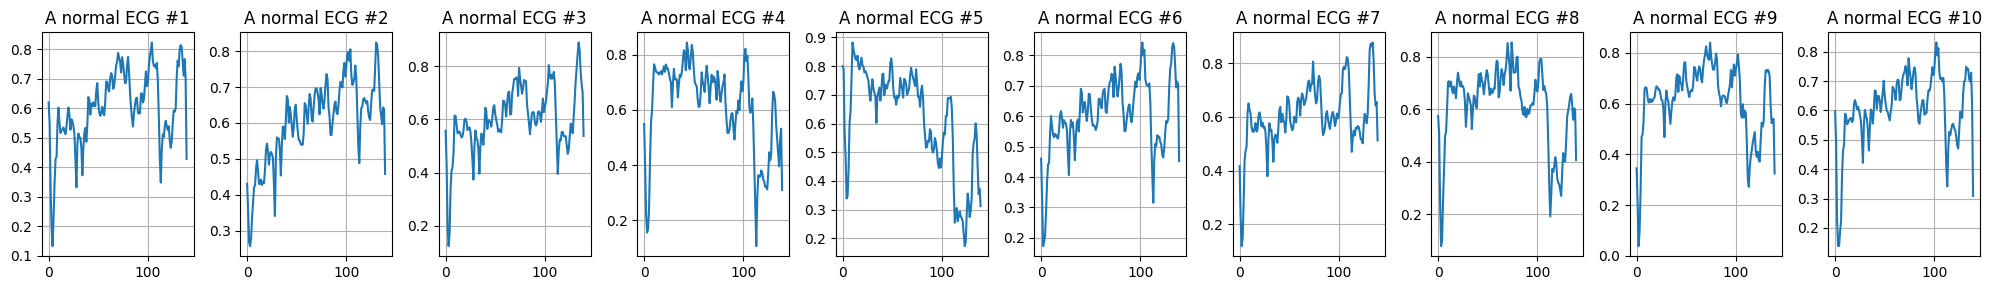

In [9]:
# 한 줄에 10개의 서브플롯을 생성합니다.
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 3))

# 각 서브플롯에 대해 ECG 데이터를 플롯합니다.
for i in range(10):
    axes[i].plot(normal_X_train[i])
    axes[i].set_title(f"A normal ECG #{i+1}")
    axes[i].grid()

plt.tight_layout()
plt.show()

비정상 ECG 시각화

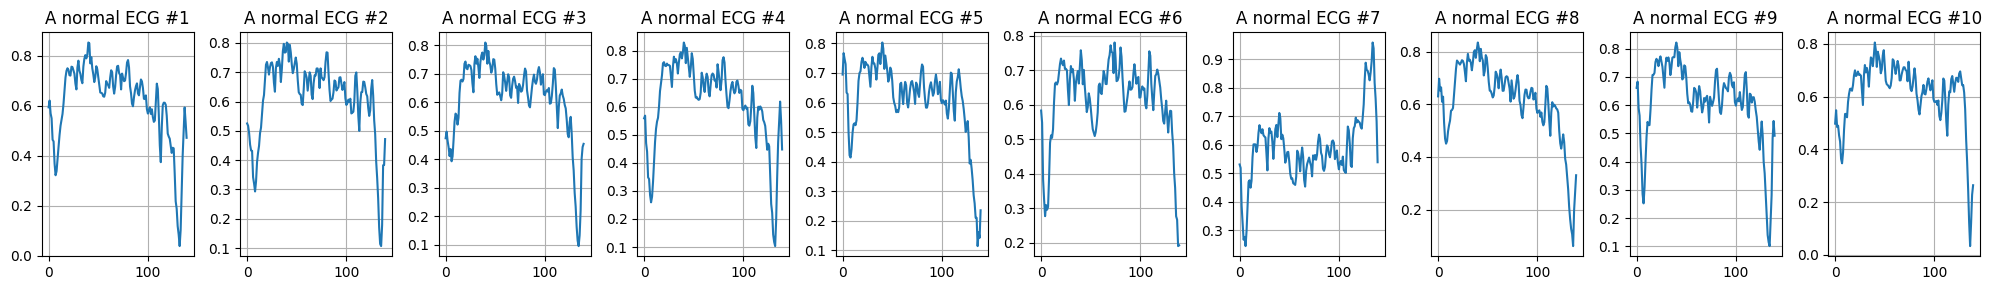

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 3))

# 각 서브플롯에 대해 ECG 데이터를 플롯합니다.
for i in range(10):
    axes[i].plot(abnormal_X_train[i])
    axes[i].set_title(f"A normal ECG #{i+1}")
    axes[i].grid()

plt.tight_layout()
plt.show()

### 이상 탐지를 위한 RNN
데이터 세트의 레이블에 액세스할 수 있으므로 이상 감지를 이진 분류 지도 학습 문제로 설정할 수 있습니다.

In [11]:
X_train_rnn = np.expand_dims(X_train, axis=2)
X_test_rnn = np.expand_dims(X_test, axis=2)
X_train_rnn.shape, X_test_rnn.shape

((3998, 140, 1), (1000, 140, 1))

In [12]:
# RNN 모델 생성
model = tf.keras.Sequential()
model.add(layers.LSTM(100, input_shape=(X_train_rnn.shape[1],X_train_rnn.shape[2])))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model.compile(loss='binary_crossentropy', optimizer='adam')
history = model.fit(X_train_rnn, y_train, epochs=20, batch_size=256)

Epoch 1/20
16/16 [==============================] - 9s 29ms/step - loss: 0.6414
Epoch 2/20
16/16 [==============================] - 0s 25ms/step - loss: 0.4492
Epoch 3/20
16/16 [==============================] - 0s 21ms/step - loss: 0.2876
Epoch 4/20
16/16 [==============================] - 0s 20ms/step - loss: 0.1674
Epoch 5/20
16/16 [==============================] - 0s 15ms/step - loss: 0.1309
Epoch 6/20
16/16 [==============================] - 0s 17ms/step - loss: 0.0954
Epoch 7/20
16/16 [==============================] - 0s 14ms/step - loss: 0.0867
Epoch 8/20
16/16 [==============================] - 0s 13ms/step - loss: 0.0882
Epoch 9/20
16/16 [==============================] - 0s 12ms/step - loss: 0.0929
Epoch 10/20
16/16 [==============================] - 0s 15ms/step - loss: 0.0767
Epoch 11/20
16/16 [==============================] - 0s 16ms/step - loss: 0.0722
Epoch 12/20
16/16 [==============================] - 0s 12ms/step - loss: 0.1106
Epoch 13/20
16/16 [==================

Text(0.5, 1.0, 'Training Loss')

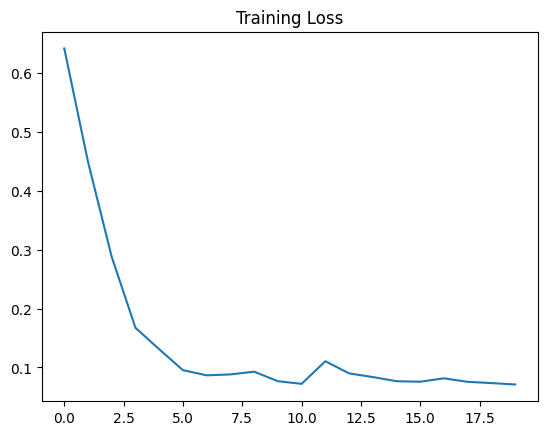

In [14]:
plt.plot(history.history['loss'])
plt.title('Training Loss')

In [15]:
# Test set 정상/비정상 분류
preds = model.predict(X_test_rnn) > 0.5

# metric 계산
accuracy_test_rnn= accuracy_score(preds, y_test)
print('Accuracy = ',accuracy_test_rnn)

precision_test_rnn=precision_score(preds, y_test)
print('Precision = ',precision_test_rnn)

recall_test_rnn=recall_score(preds, y_test)
print('Recall = ',recall_test_rnn)

32/32 [==============================] - 1s 6ms/step
Accuracy =  0.98
Precision =  0.9898477157360406
Recall =  0.9766277128547579


### 이상 감지를 위한 오토인코더
autoencoder의 목적은 주어진 입력의 재구성 오류를 최소화하는 것입니다. 따라서 우리는 최소한의 오류로 이러한 예를 재구성할 수 있도록 정상 심전도 시퀀스에 대해서만 자동 인코더를 훈련할 것입니다.   
비정상적인 리듬은 정상 시퀀스보다 재구성 오류가 더 높아야 하므로 재구성 오류가 고정 임계값보다 높은 경우의 리듬을 이상으로 분류할 수 있습니다.

In [16]:
class AnomalyDetectorAE(Model):
    def __init__(self):
        super(AnomalyDetectorAE, self).__init__()

        # encoder network
        self.encoder = tf.keras.Sequential([
              Dense(32, activation="relu"),
              Dense(16, activation="relu"),
              Dense(8, activation="relu")])

        # decoder network
        self.decoder = tf.keras.Sequential([
              Dense(16, activation="relu"),
              Dense(32, activation="relu"),
              Dense(140, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetectorAE()

In [17]:
autoencoder.compile(optimizer='adam', loss='mae')

오토인코더는 정상 ECG만 사용하여 훈련됩니다.

In [18]:
history = autoencoder.fit(normal_X_train, normal_X_train,
                                      epochs=20, batch_size=256,
                                      validation_data=(normal_X_test, normal_X_test),
                                      shuffle=True)

Epoch 1/20
10/10 [==============================] - 2s 25ms/step - loss: 0.1353 - val_loss: 0.1275
Epoch 2/20
10/10 [==============================] - 0s 9ms/step - loss: 0.1210 - val_loss: 0.1117
Epoch 3/20
10/10 [==============================] - 0s 8ms/step - loss: 0.1046 - val_loss: 0.0946
Epoch 4/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0873 - val_loss: 0.0774
Epoch 5/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0710 - val_loss: 0.0632
Epoch 6/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0587 - val_loss: 0.0542
Epoch 7/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0515 - val_loss: 0.0491
Epoch 8/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0474 - val_loss: 0.0467
Epoch 9/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0458 - val_loss: 0.0462
Epoch 10/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0455 - val_loss: 0.0461
Epoch 11/20
10/10 

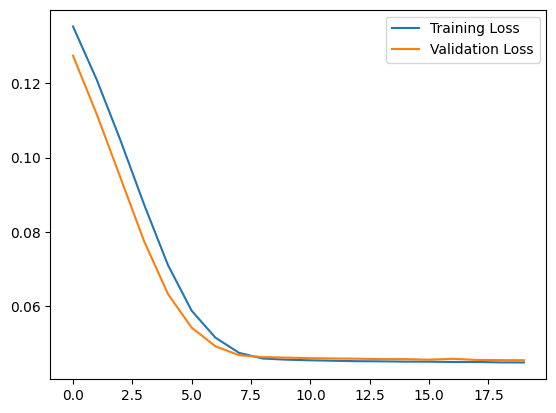

In [19]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

정상 데이터를 오토인코더로 인코딩과 디코딩을 한 후의 신호를 살펴봅니다.

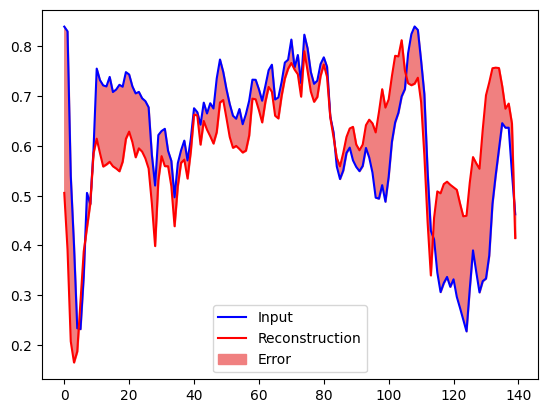

In [20]:
encoded_signals = autoencoder.encoder(normal_X_test).numpy()
decoded_signals = autoencoder.decoder(encoded_signals).numpy()

plt.plot(normal_X_test[0], 'b', label="Input")
plt.plot(decoded_signals[0], 'r', label="Reconstruction")
plt.fill_between(np.arange(140), decoded_signals[0], normal_X_test[0],
                        color='lightcoral', label="Error")
plt.legend()
plt.show()

비정상적 데이터 예제에 대한 유사한 플롯 만들기:

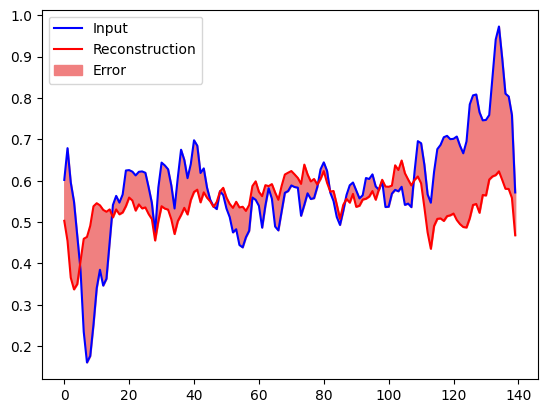

In [21]:
encoded_signals = autoencoder.encoder(abnormal_X_test).numpy()
decoded_signals = autoencoder.decoder(encoded_signals).numpy()

plt.plot(abnormal_X_test[0], 'b', label="Input")
plt.plot(decoded_signals[0], 'r', label="Reconstruction")
plt.fill_between(np.arange(140), decoded_signals[0], abnormal_X_test[0],
                        color='lightcoral', label="Error")
plt.legend()
plt.show()

### 이상 감지
재구성 손실이 고정 임계값보다 큰지 여부를 계산하여 이상을 감지합니다. 이를 위해 훈련 세트의 정상 예제에 대한 평균 평균 오류를 계산한 다음 재구성 오류가 훈련 세트의 표준 편차보다 높으면 미래 예제를 비정상적인 것으로 분류합니다.

훈련 세트의 정상 ECG에 대한 재구성 오류를 시각화 합니다.

73/73 [==============================] - 0s 2ms/step


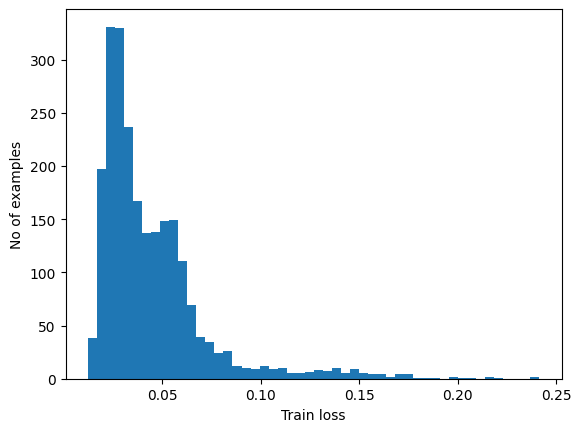

In [22]:
reconstructions = autoencoder.predict(normal_X_train)
train_loss = tf.keras.losses.mae(reconstructions, normal_X_train).numpy()

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

평균 + 1 표준편차인 임계값을 선택합니다.

In [23]:
threshold_ae = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold_ae)

Threshold:  0.07328003948340324


테스트 세트의 대부분의 비정상 example은 임계값보다 재구성 오류가 더 큽니다. 임계값을 변경하여 분류기의 정밀도와 재현율을 조정할 수 있습니다.

53/53 [==============================] - 0s 3ms/step


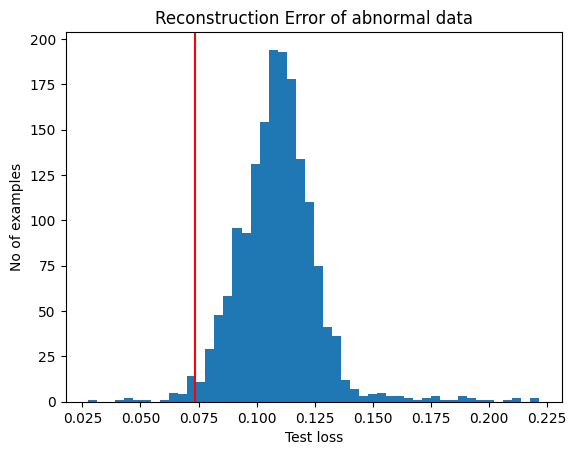

In [24]:
reconstructions = autoencoder.predict(abnormal_X_train)
test_loss = tf.keras.losses.mae(reconstructions, abnormal_X_train).numpy()

plt.hist(test_loss, bins=50)
plt.axvline(threshold_ae, c='r')
plt.title("Reconstruction Error of abnormal data")
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

재구성 오류가 임계값보다 큰 경우 ECG를 이상으로 분류합니다.  
재구성 오류를 이용한 이상치 예측과 label 을 비교하여 performance 를 측정합니다.

In [25]:
def predict(model, data, threshold):
    reconstructions = model.predict(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, preds)))
    print("Precision = {}".format(precision_score(labels, preds)))
    print("Recall = {}".format(recall_score(labels, preds)))

In [26]:
preds = predict(autoencoder, X_test, threshold_ae)
print_stats(preds.numpy(), y_test)

32/32 [==============================] - 0s 2ms/step
Accuracy = 0.939
Precision = 0.988929889298893
Recall = 0.9069373942470389


### 이상 감지를 위한 Variational Autoencoder
오토인코더는 훈련 데이터에 과적합되는 경향이 강합니다. 이 문제를 완화하도록 설계된 VAE를 사용합니다.

### Sampling Class

먼저 'Sampling' 클래스를 빌드합니다. 이것은 인코더 출력의 평균 (mu) 및 표준 편차 (sigma)와 함께 가우스 노이즈 입력을 제공하는 맞춤형 Keras 레이어입니다. 실제로 이 레이어의 출력은 다음 방정식으로 제공됩니다.

$$z = \mu + e^{0.5\sigma} * \epsilon  $$

여기서 $\mu$ = mean, $\sigma$ = standard deviation, $\epsilon$ = random sample

In [27]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        """인코더의 출력과 결합하여 무작위 샘플을 생성합니다.
        Args:
          inputs -- 인코더로부터의 출력 텐서 (평균 mu, 표준편차 sigma)
        Returns:
          무작위 샘플이 결합된 `inputs` 텐서
        """
        # 인코더의 출력을 분해합니다.
        mu, sigma = inputs

        # 배치의 크기와 차원을 얻습니다.
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]

        # 무작위 텐서를 생성합니다.
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        # 재매개변수화 기법을 적용합니다.
        return mu + tf.math.exp(0.5 * sigma) * epsilon

### Kullback–Leibler Divergence
모델의 생성 능력을 향상 시키려면 잠재 공간에 도입된 랜덤 정규 분포를 고려해야 합니다. 이를 위해 [Kullback–Leibler Divergence](https://arxiv.org/abs/2002.07514)가 계산되어 재구성 손실에 추가됩니다. 공식은 아래 함수에서 정의됩니다.

In [28]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
    """Kullback-Leibler 발산(KLD) 계산
    Args:
    inputs -- 데이터셋 배치
    outputs -- Sampling 층의 출력
    mu -- 평균
    sigma -- 표준 편차

    Returns:
    KLD 손실
    """
    # KLD 계산 공식 적용
    kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
    # 배치 내 평균을 계산하고 -0.5를 곱하여 최종 KLD 손실을 계산
    kl_loss = tf.reduce_mean(kl_loss) * -0.5

    return kl_loss

In [29]:
LATENT_DIM = 2
input_dim = normal_X_train.shape[-1]
input_dim

140

이제 전체 VAE 모델을 정의할 수 있습니다. KL reconstruction loss를 추가하기 위해 `model.add_loss()`를 사용합니다. 이 손실을 계산하는 것은 `y_true`와 `y_pred`를 사용하지 않으므로 `model.compile()`에서 사용할 수 없습니다.

- add_loss() 메서드 : 손실이 있는 경우, 자동으로 합산되어 주 손실에 추가

In [30]:
encoder_input = Input(shape=(input_dim,))
x = Dense(32, activation='relu')(encoder_input)
x = Dense(16, activation='relu')(x)
mu = Dense(LATENT_DIM)(x)
sigma = Dense(LATENT_DIM)(x)

z = Sampling()((mu, sigma))

encoder = Model(encoder_input, [mu, sigma, z])

decoder_input = Input(shape=(LATENT_DIM,))
x = Dense(16, activation='relu')(decoder_input)
x = Dense(32, activation='relu')(x)
decoded = Dense(input_dim, activation='sigmoid')(x)

decoder = Model(decoder_input, decoded)

In [31]:
vae_input = encoder_input
# 인코더를 통과시켜 평균(mu), 표준 편차(sigma), 그리고 잠재 공간의 벡터(z)를 얻습니다.
mu, sigma, z = encoder(vae_input)
# 디코더를 사용하여 잠재 공간의 벡터(z)로부터 입력을 재구성
reconstructed = decoder(z)

# 입력과 재구성된 값을 사용하여 VAE 모델을 생성
vae = Model(vae_input, reconstructed)
# Kullback-Leibler 발산을 계산하는 함수를 사용하여 손실을 추가합니다. 이는 잠재 공간의 분포가
# 우리가 원하는 분포(예: 표준 정규 분포)에 가까워지도록 돕습니다.
loss = kl_reconstruction_loss(vae_input, z, mu, sigma)
# add_loss는 사용자 정의 손실을 추가하는 메서드
vae.add_loss(loss)

In [32]:
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# 학습 과정에서의 평균 손실을 추적
loss_metric = tf.keras.metrics.Mean()
# 평균 제곱 오차 손실 함수를 사용합니다.
mse_loss = tf.keras.losses.MeanSquaredError()

In [33]:
epochs = 40

@tf.function
def train_step(x_batch_train):
    with tf.GradientTape() as tape:
        # VAE 모델에 배치 입력을 공급하여 재구성된 결과를 얻음
        reconstructed = vae(x_batch_train)

        # 재구성 손실을 계산
        loss = mse_loss(x_batch_train, reconstructed)

        # KLD 정규화 손실을 추가
        loss += sum(vae.losses)  # vae.losses에는 KLD 손실이 포함됨

    # 그라디언트를 계산하고 가중치 업데이트
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))
    return loss

# 테스트 스텝 추가
@tf.function
def test_step(x_batch_test):
    reconstructed = vae(x_batch_test)
    loss = mse_loss(x_batch_test, reconstructed)
    loss += sum(vae.losses)
    return loss

# 손실 지표를 두 개로 분리
train_loss_metric = tf.keras.metrics.Mean()
test_loss_metric = tf.keras.metrics.Mean()

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))

    # 에포크 시작 시 지표 리셋
    train_loss_metric.reset_states()
    test_loss_metric.reset_states()

    for step, (x_batch_train, x_batch_test) in enumerate(zip(train_ds, test_ds)):
        # 훈련 스텝
        train_loss = train_step(x_batch_train)
        train_loss_metric(train_loss)

        # 테스트 스텝
        test_loss = test_step(x_batch_test)
        test_loss_metric(test_loss)

        # 매 500 스텝마다 결과 표시
        if step % 500 == 0:
            print('Epoch: %s step: %s' % (epoch, step))
            print('Mean training loss = %s' % (train_loss_metric.result().numpy()))
            print('Mean test loss = %s' % (test_loss_metric.result().numpy()))


Start of epoch 0
Epoch: 0 step: 0
Mean training loss = 0.053107455
Mean test loss = 0.04043309
Start of epoch 1
Epoch: 1 step: 0
Mean training loss = 0.028811827
Mean test loss = 0.028617518
Start of epoch 2
Epoch: 2 step: 0
Mean training loss = 0.027398217
Mean test loss = 0.027703466
Start of epoch 3
Epoch: 3 step: 0
Mean training loss = 0.026120443
Mean test loss = 0.026019279
Start of epoch 4
Epoch: 4 step: 0
Mean training loss = 0.024935294
Mean test loss = 0.024722964
Start of epoch 5
Epoch: 5 step: 0
Mean training loss = 0.02296275
Mean test loss = 0.02325227
Start of epoch 6
Epoch: 6 step: 0
Mean training loss = 0.021870462
Mean test loss = 0.021890273
Start of epoch 7
Epoch: 7 step: 0
Mean training loss = 0.019983338
Mean test loss = 0.020004304
Start of epoch 8
Epoch: 8 step: 0
Mean training loss = 0.018440817
Mean test loss = 0.018410338
Start of epoch 9
Epoch: 9 step: 0
Mean training loss = 0.016065175
Mean test loss = 0.016789077
Start of epoch 10
Epoch: 10 step: 0
Mean tr

## Reconstruction Error 시각화

32/32 [==============================] - 0s 2ms/step


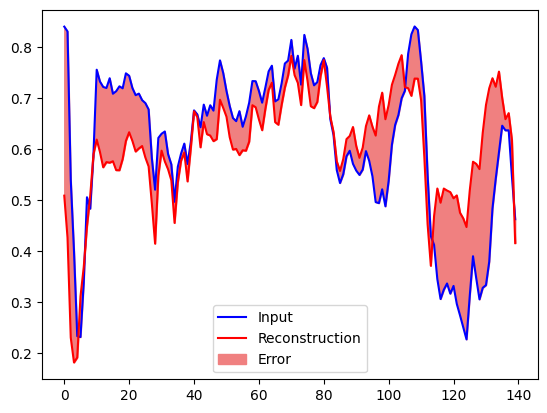

In [34]:
decoded_imgs = vae.predict(X_test)
plt.plot(normal_X_test[0], 'b', label="Input")
plt.plot(decoded_imgs[0], 'r', label="Reconstruction")
plt.fill_between(np.arange(140), decoded_imgs[0], normal_X_test[0],
                        color='lightcoral', label="Error")
plt.legend()
plt.show()

이전과 마찬가지로 평균 절대 오차에 표준 편차 1을 더한 값에서 임계값을 계산합니다.

73/73 [==============================] - 0s 2ms/step


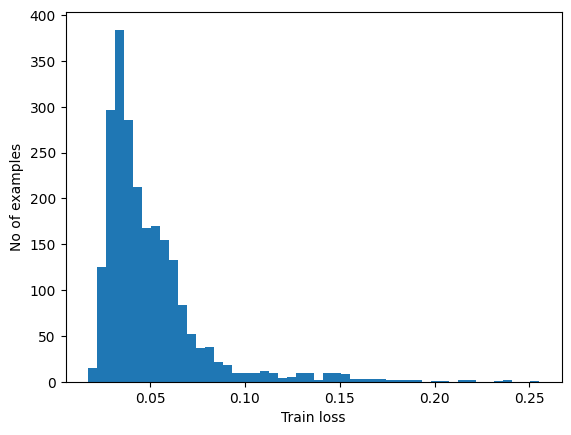

In [35]:
reconstructions = vae.predict(normal_X_train)
train_loss = tf.keras.losses.mae(reconstructions, normal_X_train).numpy()
plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [36]:
threshold_vae = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold_vae)

Threshold:  0.07770451994568936


13/13 [==============================] - 0s 2ms/step


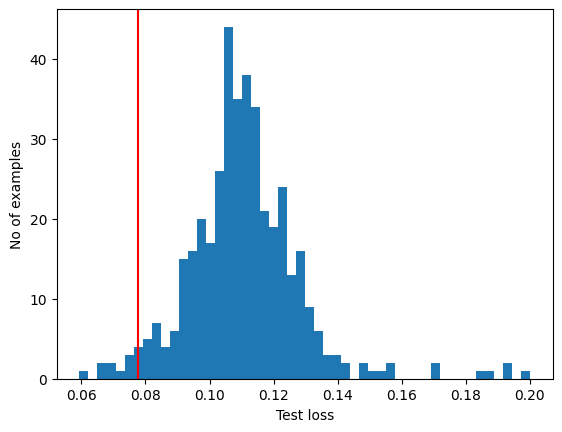

In [37]:
reconstructions = vae.predict(abnormal_X_test)
test_loss = tf.keras.losses.mae(reconstructions, abnormal_X_test).numpy()

plt.hist(test_loss, bins=50)
plt.axvline(threshold_vae,c='r')
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

재구성 오류가 임계값보다 큰 경우 ECG를 이상으로 분류합니다.

variational autoencoder

In [38]:
preds = predict(vae, X_test, threshold_vae)
print("Variational Autoencoder")
print_stats(preds, y_test)

32/32 [==============================] - 0s 3ms/step
Variational Autoencoder
Accuracy = 0.932
Precision = 0.9798165137614679
Recall = 0.9035532994923858


- autoencoder

In [39]:
preds = predict(autoencoder, X_test, threshold_ae)
print("Autoencoder")
print_stats(preds, y_test)

32/32 [==============================] - 0s 2ms/step
Autoencoder
Accuracy = 0.939
Precision = 0.988929889298893
Recall = 0.9069373942470389


RNN 이진 분류 모델

In [40]:
print("RNN as classifier")
print('Accuracy = ',accuracy_test_rnn)
print('Precision = ',precision_test_rnn)
print('Recall = ',recall_test_rnn)

RNN as classifier
Accuracy =  0.98
Precision =  0.9898477157360406
Recall =  0.9766277128547579
